# Variational Autoencoders
1. In an autoencoder each images is mapped directly to one point in the latent space . In Variational Autoencoders , each images is instead mapped to a     multivariate normal distribution around a point in the latent space .
2. We can sample a point z from a normal distribution with mean μ and standard deviation σ using the following equation:  z = μ + σε
3. The encoder will map each input to a mean vector and a variance vector and does not need to worry about covariance between dimensions . Variational autoencoders assums that there is no correlation between dimensions in the latent space.
4. *z_mean* --> The mean point of the distibution
   *z_log_var* --> The logarithm of the variance of each dimension
5. z = z_mean + z_sigma * epsilon  --> sample a point z from the distribution 

Why does this small change to the encoder help ?

Previously, we saw that there was no requirement for the latent space to be continous 
even if the point (–2, 2) decodes to a well-formed image of a sandal, there’s a 
requirement for (–2.1, 2.1) to look similar. Now, since we are sampling a random
point from an area around z_mean, the decoder must ensure that all points in the
same neighborhood produce very similar images when decoded, so that the reconstruction
loss remains small. This is a very nice property that ensures that even when
we choose a point in the latent space that has never been seen by the decoder, it is
likely to decode to an image that is well formed.

**To Summarize** -- the NN as an encoder will take ecah input image and encode it to two vectors that together define a multivariate normal 
distribution in the latent space.

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

In [17]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500
LEARNING_RATE = 0.0005

In [3]:
from tensorflow.keras import datasets
(x_train , y_train) , (x_test , y_test) = datasets.fashion_mnist.load_data()

In [4]:
def preprocess(data):
    data = data.astype("float32") / 255.0
    data = np.pad(data , ((0,0) , (2,2) , (2,2)) , constant_values = 0.0)
    data = np.expand_dims(data , -1)
    return data

In [5]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

**Subclassing the class layer** - You can create a new custom layer in keras by subclassing the Layer class and defining the call
method which describe how a tensor is transformed by the layer.

In [6]:
#The Sampling class is a custom layer in a neural network that implements the reparameterization trick used in Variational Autoencoders (VAEs). 
# This trick allows you to sample a point from a distribution defined by a mean (z_mean) and a variance (z_log_var), but in a way that allows
# gradients to pass through the sampling process.

class Sampling(tf.keras.layers.Layer):
    def call(self , inputs):
        z_mean , z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim)) # This adds randomness to the sampling process.
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # Reparameterization Trick

You can't use the Sequential API while building the encoder . You have to use the Functional API . The Sequential model assumes a linear stack of layers with a single input and output. Since the Sampling layer requires both z_mean and z_log_var as inputs, the Sequential API cannot handle this.

In [7]:
# The encoder

encoder_input = tf.keras.layers.Input(
    shape = (IMAGE_SIZE, IMAGE_SIZE, 1) , name = "encoder_input"
)
conv_layer_1 = tf.keras.layers.Conv2D(32 , (3,3) , strides = 2 , activation = "relu" , padding = "same")
conv_layer_2 = tf.keras.layers.Conv2D(64 , (3,3) , strides = 2 , activation = "relu" , padding = "same")
conv_layer_3 = tf.keras.layers.Conv2D(128 , (3,3) ,strides = 2 , activation = "relu" , padding = "same")
flattening_layer = tf.keras.layers.Flatten()
output_1 = tf.keras.layers.Dense(EMBEDDING_DIM , name = "z_mean")
output_2 = tf.keras.layers.Dense(EMBEDDING_DIM , name= "z_log_var")

x = conv_layer_1(encoder_input)
x = conv_layer_2(x)
x = conv_layer_3(x)

shape_before_flattening = K.int_shape(x)[1:]

x = flattening_layer(x)
z_mean = output_1(x)
z_log_var = output_2(x)
z = Sampling()([z_mean , z_log_var])

encoder_model = tf.keras.models.Model(inputs = [encoder_input] , outputs = [z_mean , z_log_var , z] , name = "encoder_model")

In [8]:
encoder_model.summary()

Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)    │ (None, 32, 32, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 16, 16, 32)        │             320 │ encoder_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 8, 8, 64)          │          18,496 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 4, 4, 128)         │          73,856 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 2048)              │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_mean (Dense)                │ (None, 2)                 │           4,098 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_log_var (Dense)             │ (None, 2)                 │           4,098 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sampling (Sampling)           │ (None, 2)                 │               0 │ z_mean[0][0],              │
│                               │                           │                 │ z_log_var[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# The decoder - the decoder architecture will be the same .

decoder_input = tf.keras.layers.Input(shape = (EMBEDDING_DIM,) , name = "decoder_input")
hidden_layer = tf.keras.layers.Dense(np.prod(shape_before_flattening))
reshaping_layer = tf.keras.layers.Reshape(shape_before_flattening)
conv_transpose_1 = tf.keras.layers.Conv2DTranspose(128 , (3,3) , strides = 2 , activation = "relu" , padding = "same")
conv_transpose_2 = tf.keras.layers.Conv2DTranspose(64 , (3,3) , strides = 2 , activation = "relu" , padding = "same")
conv_transpose_3 = tf.keras.layers.Conv2DTranspose(32 , (3,3) , strides = 2 , activation = "relu" , padding = "same")
output_layer = tf.keras.layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)

x = hidden_layer(decoder_input)
x = reshaping_layer(x)
x = conv_transpose_1(x)
x = conv_transpose_2(x)
x = conv_transpose_3(x)
decoder_output = output_layer(x)

decoder_model = tf.keras.models.Model(inputs = [decoder_input] , outputs = [decoder_output] , name = "decoder_model")

In [10]:
decoder_model.summary()

Model: "decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

## Loss Function

1. **Reconstruction Loss**
2. **Kullback-Leibler Divergence** - How much our normal distribution with parameters z_mean and z_log_var differ from a standard normal distribution . 

``` bash
    kl_loss = -0.5 * sum(1 + z_log_var - z_mean ^ 2 - exp(z_log_var))

The KL Divergence term penalize the network for encoding observation to z_mean and z_log_var variables that differ significantly from the parameters of a standard normal distribution , namely z_mean = 0 and z_log_var = 0.

* β-VAE has a parameter that weights the KL Divergence and the reconstruction loss.
* In  the original paper of VAE the two losses were just added.
* The KL Divergence term froces all the encoded distributions towards the standard normal distribution , there is less chance that large gaps will form between points clusters.

In [40]:
class VAE(tf.keras.models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * tf.keras.losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * tf.keras.losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [41]:
vae = VAE(encoder_model, decoder_model)

In [42]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [43]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - kl_loss: 5.0668 - reconstruction_loss: 129.0581 - total_loss: 134.1248 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 52s 87ms/step - kl_loss: 5.1296 - reconstruction_loss: 127.8588 - total_loss: 132.9884 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 55s 92ms/step - kl_loss: 5.1543 - reconstruction_loss: 127.1416 - total_loss: 132.2958 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 54s 90ms/step - kl_loss: 5.1801 - reconstruction_loss: 127.1025 - total_loss: 132.2825 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 54s 90ms/step - kl_loss: 5.2240 - reconstruction_loss: 126.6015 - total_loss: 131.825

## Reconstruct using the VAE

In [44]:
def plot_images(images, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i, :, :, 0], cmap='gray')  
        ax.axis('off')
        ax.set_title(f"Image {i+1}")  

    plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Example real clothing items


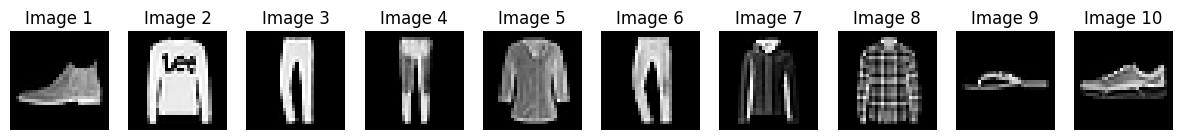

Reconstructions


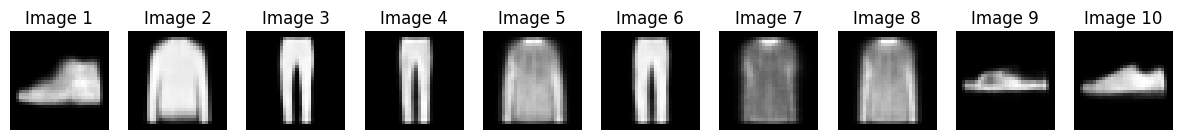

In [45]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
plot_images(example_images, 10)
print("Reconstructions")
plot_images(reconstructions, 10)

# Let's see latent space

In [47]:
z_mean, z_var, z = encoder_model.predict(example_images)

print(z[:10])

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[[-0.45249683 -1.4236002 ]
 [-1.1026114   0.93585604]
 [ 2.1192548   1.9443367 ]
 [ 2.1815908   0.4885835 ]
 [-0.3118658   0.09645574]
 [ 1.5677265   1.5284374 ]
 [ 0.3778027   0.05662713]
 [ 0.03941421  0.13018957]
 [ 1.7602141  -1.4647895 ]
 [ 0.9475723  -1.19685   ]]


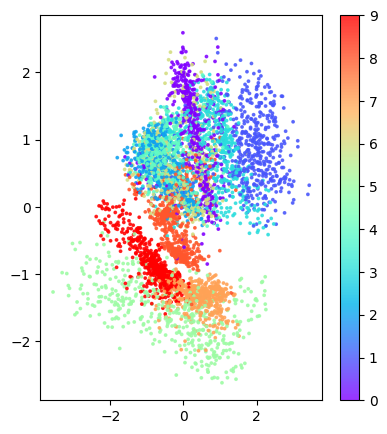

In [57]:
figsize = 5

fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
plt.show()

## Generating new images

In [53]:
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

reconstructions = decoder_model.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [59]:
z_sample

array([[-0.43053447, -0.51105787],
       [-1.36394252, -1.11773362],
       [-1.3060055 ,  0.87819904],
       [ 0.70225933, -0.12602059],
       [-0.39358724, -0.66483474],
       [ 0.71603521,  0.30812653],
       [-0.38633294, -0.32036051],
       [ 1.56654892, -0.47768408],
       [ 1.41046014, -1.98723413],
       [ 0.82633603, -0.13179228],
       [-2.04599318,  0.55595946],
       [-1.50354894,  1.10785646],
       [-0.90269967,  0.9570458 ],
       [-0.29122004, -0.11318963],
       [-0.74064996,  1.39635903],
       [-1.08350893,  0.06022077],
       [ 1.15218727,  0.21330166],
       [-0.07313721,  1.20137419]])

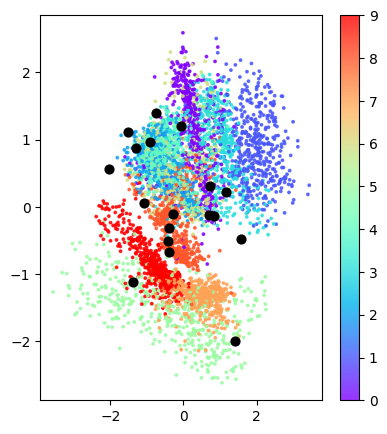

In [56]:
figsize = 5

fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#000000", alpha=1, s=40)
plt.colorbar(plot_1)
plt.show()

Newly generated images using VAE


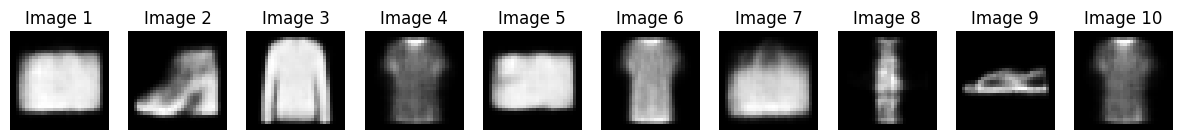

In [60]:
print("Newly generated images using VAE")
plot_images(reconstructions, 10)